# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [2]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.6206601950609655
 0.8482833941245002
 0.08877962747102819
 0.5575612468535585
 0.17054108353131792
 0.49639220934239237
 0.027396600605475996
 0.40292730655410747
 0.7077830460019822
 0.08461183326608845
 ⋮
 0.7134299373998377
 0.899749877757914
 0.8415853086937702
 0.23294173784322947
 0.28242497530982746
 0.4547910216086143
 0.9091965082948017
 0.7688723961284671
 0.8964894552716214

In [12]:
sum(a)

5.001582669916378e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [13]:
@time sum(a)

  0.002240 seconds (1 allocation: 16 bytes)


5.001582669916378e6

In [14]:
@time sum(a)

  0.001981 seconds (1 allocation: 16 bytes)


5.001582669916378e6

In [15]:
@time sum(a)

  0.001986 seconds (1 allocation: 16 bytes)


5.001582669916378e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [16]:
using Pkg
Pkg.add("BenchmarkTools")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [17]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [19]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum (generic function with 1 method)

In [20]:
c_sum(a)

5.00158266991621e6

In [23]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [24]:
c_sum(a) - sum(a)  

-1.685693860054016e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [25]:
?isapprox

ErrorException: syntax: invalid identifier name "?"

We can now benchmark the C code directly from Julia:

In [26]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 526 samples with 1 evaluation.
 Range (min … max):  9.334 ms …  9.879 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.497 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.510 ms ± 82.510 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

               ▂▁▂█▆▅▂▆▅█▆▇▆▄   ▂      ▁                      
  ▂▁▂▂▄▄▅▄▄█▇█▆██████████████▆█▆█▅▆█▆▄▆█▆▄▅▃▁▄▄▂▁▃▂▄▃▂▃▁▃▄▁▄ ▄
  9.33 ms        Histogram: frequency by time        9.75 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [27]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 9.333791 msec


In [28]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 9.33379

In [29]:
using Plots
gr()

Plots.GRBackend()

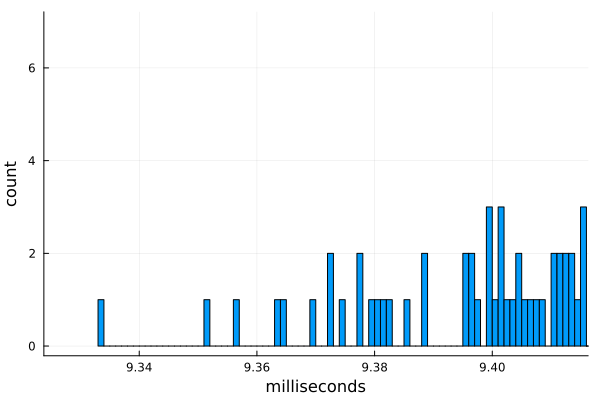

In [30]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [32]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

clang: warning: argument unused during compilation: '-msse3' [-Wunused-command-line-argument]


c_sum_fastmath (generic function with 1 method)

In [33]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 3506 samples with 1 evaluation.
 Range (min … max):  1.318 ms …   3.054 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.365 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.415 ms ± 127.398 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅▆█▇▆▆▅▅▅▄▃▃▂▁▁▁   ▁  ▁     ▁▁                              ▁
  ███████████████████████▇█▇███████▆▇▇█▇▆█▇▇▇█▆▇▆▆▆▅▇▄▅▅▅▄▅▅▄ █
  1.32 ms      Histogram: log(frequency) by time      1.89 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [21]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

1.781208

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [34]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...


   Installed VersionParsing ─ v1.3.0


   Installed Conda ────────── v1.9.0
   Installed PyCall ───────── v1.96.1


    Updating `~/.julia/environments/v1.9/Project.toml`
  [438e738f] + PyCall v1.96.1
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [8f4d0f93] + Conda v1.9.0
  [438e738f] + PyCall v1.96.1
  [81def892] + VersionParsing v1.3.0


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/915ebe6f0e7302693bdd8eac985797dba1d25662/build.log`


    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/43d304ac6f0354755f1d60730ece8c499980f7ba/build.log`


Precompiling project...


  ✓ VersionParsing


  ✓ Conda


  ✓ PyCall
  3 dependencies successfully precompiled in 8 seconds. 171 already precompiled.


In [24]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [25]:
pysum(a)

5.000406093458116e6

In [26]:
pysum(a) ≈ sum(a)

true

In [27]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  875.812 ms … 887.689 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     882.182 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   882.005 ms ±   4.940 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █         █       █                           █       █     █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁█ ▁
  876 ms           Histogram: frequency by time          888 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [28]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38288
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [29]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `~/Desktop/Introduction-to-Julia/Project.toml`
  [8f4d0f93] + Conda v1.5.2
  No Changes to `~/Desktop/Introduction-to-Julia/Manifest.toml`


In [30]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/logankilpatrick/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

## Package Plan ##

  environment location: /Users/logankilpatrick/.julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       hecd8cb5_1         113 KB
    conda-4.10.3               |   py38hecd8cb5_0         2.9 MB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  ca-certificates                      2021.5.25-hecd8cb5_1 --> 2021.7.5-hecd8cb5_1
  conda                               4.10.1-py38hecd8cb5_1 --> 4.10.3-py38hecd8cb5_0



ca-certificates-2021 | 113 KB    | #################################### | 100% 
conda-4.10.3         | 2.9 MB    | #################################### | 100% 
Preparing transaction: ...working... done
Verifying transa

In [31]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 2304 samples with 1 evaluation.
 Range (min … max):  1.913 ms …   6.826 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.025 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.148 ms ± 356.848 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ██▆▅▄▄▄▅▅▄▄▃▃▃▃▂▂▂▁ ▁                                       ▁
  ███████████████████████▇▇█▇▇▇▁▇▆▆▆▆▄▇▅▆▆▅▆▅▁▁▁▁▅▄▅▆▅▅▅▄▄▄▄▅ █
  1.91 ms      Histogram: log(frequency) by time      3.63 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [32]:
numpy_sum(a)

5.000406093458153e6

In [33]:
numpy_sum(a) ≈ sum(a)

true

In [34]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.38288
  "Python numpy"    => 1.91263
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 5. Python, hand-written 

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff7d13c8b80>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.012 s …  1.027 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.018 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.019 s ± 6.023 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       █              █        █                      █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  110 s         Histogram: frequency by time         130 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [37]:
sum_py(a)

5.000406093458116e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "C -ffast-math"       => 1.78121

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [40]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [41]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 2387 samples with 1 evaluation.
 Range (min … max):  1.861 ms …   6.781 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.980 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.074 ms ± 274.199 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▂█▃                                                         
  ▃███▇▆▅▄▅▅▅▅▄▃▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▃
  1.86 ms         Histogram: frequency by time         370 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [42]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 7. Julia (hand-written) 

In [35]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [44]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 510 samples with 1 evaluation.
 Range (min … max):  9.387 ms …  13.864 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.651 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.793 ms ± 471.368 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▄  ▃                                                       
  ███████▇▇▆▅▅▄▅▆▄▄▅▄▄▄▄▃▃▂▃▃▁▃▂▂▃▂▂▂▁▁▁▁▂▁▁▂▁▁▂▁▁▁▂▁▂▂▁▁▁▂▂▂ ▃
  9.39 ms         Histogram: frequency by time        11.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [45]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Julia hand-written"  => 9.387
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "Julia built-in"      => 1.8605
  "C -ffast-math"       => 1.78121

# 8. Julia (hand-written w. simd) 

In [46]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [47]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 2023 samples with 1 evaluation.
 Range (min … max):  2.370 ms …  3.173 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.429 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.454 ms ± 67.874 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        █▇▆▅▄▄▃▃▃▃▂▂▂▂    ▁ ▁▁                               ▁
  █▄▆██████████████████████▇██▇▆▇▆▇▆▆▆▆▆▄▆▅▆▅▆▄▄▁▄▄▄▄▄▄▅▄▄▄▄ █
  2.37 ms      Histogram: log(frequency) by time     2.76 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [48]:
mysum_simd(a)

5.000406093458086e6

In [49]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 2.37012
  "C"                       => 9.38288
  "Python numpy"            => 1.91263
  "Julia hand-written"      => 9.387
  "Python hand-written"     => 1011.92
  "Python built-in"         => 875.812
  "Julia built-in"          => 1.8605
  "C -ffast-math"           => 1.78121

# Summary

In [50]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

C -ffast-math...............1.8
Julia built-in..............1.9
Python numpy................1.9
Julia hand-written simd.....2.4
C...........................9.4
Julia hand-written..........9.4
Python built-in...........875.8
Python hand-written......1011.9
